# PRÁCTICA 6
Mi objetivo en esta práctica ha sido conseguir una red con el mayor accuracy posible llegando a superar el 98% en validación.

In [1]:
import torch
import pathlib
import numpy as np
import pandas as pd
import librosa as lr
import sounddevice as sd
import matplotlib.pyplot as plt

from torch import nn, optim
from dataclasses import dataclass
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from tqdm import tqdm
from train_net import train
from scipy.io.wavfile import write
from torch.utils.data import TensorDataset, DataLoader


TRAIN = False

In [ ]:
def preprocess_audio(filename, spec_params):
    """
    Preprocesses an audio file to a mel spectrogram.

    Parameters
    ----------
    filename (str): The path to the audio file.
    spec_params (dataclass): The parameters for calculating the spectrogram.

    Returns
    -------
    S_dB (np.array): The mel spectrogram of the audio file.
    """

    audio, sample_rate = lr.load(filename, sr=spec_params.sample_rate)
    audio, _ = lr.effects.trim(audio)

    if len(audio) < 0.1 * sample_rate:
        return None

    if len(audio) < spec_params.target_length:
        audio = np.pad(audio, (0, spec_params.target_length - len(audio)), "constant")
    else:
        audio = audio[: spec_params.target_length]

    S = lr.feature.melspectrogram(
        y=audio,
        sr=sample_rate,
        n_mels=spec_params.n_mels,
        n_fft=spec_params.n_fft,
        win_length=spec_params.window_length,
        hop_length=round(spec_params.window_length / 2),
    )

    S_dB = 20 * np.log10(S + 1e-6)
    S_dB = (S_dB - np.max(S_dB)) / (np.max(S_dB) - np.min(S_dB))

    return S_dB


def create_dataset(audios_folder, data_labels, spec_params):
    """
    Creates a dataset from the audio files in a folder.

    Parameters
    ----------
    audios_folder (str): The path to the folder with the audio files.
    data_labels (dict): A dictionary with the labels for each class.
    spec_params (dataclass): The parameters for calculating the dataset spectrograms.

    Returns
    -------
    dataset (TensorDataset): The dataset with the mel spectrograms and labels.
    """
    print(f"\nCreating dataset from {audios_folder}...")

    audio_files = pathlib.Path(audios_folder).rglob("*.wav")
    # audio_files = list(audio_files)[:1000]
    audios_df = pd.DataFrame({"filename": list(audio_files)})

    audios_df["label"] = audios_df.filename.apply(lambda x: str(x).split("/")[-2])
    audios_df["value"] = audios_df.label.map(data_labels)

    specgrams = []
    labels = []
    filenames = []

    for _, audio in tqdm(audios_df.iterrows(), total=len(audios_df)):
        specgram = preprocess_audio(audio["filename"], spec_params)

        if specgram is None:
            continue

        labels.append((audio["value"]))
        specgrams.append(specgram[np.newaxis, :, :])
        filenames.append(audio["filename"])

    X_tensor = torch.tensor(np.array(specgrams), dtype=torch.float32)
    Y_tensor = torch.tensor(np.array(labels), dtype=torch.long)

    dataset = TensorDataset(X_tensor, Y_tensor)

    return dataset, filenames


def show_dataset_samples(dataset, spec_params, nrows=3, ncols=3):
    """
    Shows a grid of samples from the dataset.

    Parameters
    ----------
    dataset (TensorDataset): The dataset with the mel spectrograms and labels.
    spec_params (dataclass): The parameters for calculating the spectrogram.
    nrows (int): The number of rows in the grid.
    ncols (int): The number of columns in the grid.
    """
    _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))

    for i in range(nrows):
        for j in range(ncols):
            idx = np.random.randint(0, len(dataset))
            specgram, label = dataset[idx]

            lr.display.specshow(
                specgram[0].numpy(),
                sr=spec_params.sample_rate,
                hop_length=round(spec_params.window_length / 2),
                ax=axes[i, j],
            )

            axes[i, j].set_title(label.item())

    plt.tight_layout()
    plt.show()


def test_net(dataset_path, data_labels, spec_params, net):
    """
    Tests a neural network with a dataset. Prints the accuracy,
    confusion matrix and wrong predictions.

    Parameters
    ----------
    dataset_path (str): The path to the dataset.
    data_labels (dict): A dictionary with the labels for each class.
    spec_params (dataclass): The parameters for calculating the dataset spectrograms.
    net (nn.Module): The neural network to test.
    """
    print(f"Testing net with {dataset_path}:\n")

    test_dataset, filenames = create_dataset(dataset_path, data_labels, spec_params)
    testloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    net.eval()

    predictions = []
    real_values = []
    with torch.no_grad():
        for num in testloader:
            net_output = net(num[0])
            predictions.append(torch.argmax(net_output).item())
            real_values.append(num[1].item())

    conf_matrix = confusion_matrix(real_values, predictions)
    cm_display = metrics.ConfusionMatrixDisplay(
        conf_matrix, display_labels=data_labels.keys()
    )

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"\nAccuracy: {accuracy * 100}%")

    # print wrong predictions
    print("\nWrong predictions:")
    for i in range(len(predictions)):
        if real_values[i] != predictions[i]:
            print(
                f"Prediction: {predictions[i]}, Real: {real_values[i]}, File: {filenames[i]}"
            )

    print("\nConfusion Matrix:")
    cm_display.plot()
    cm_display.ax_.set_title(f"Confusion Matrix {dataset_path}")
    cm_display.ax_.set_xlabel("Predicted")
    cm_display.ax_.set_ylabel("Real")
    cm_display.figure_.set_size_inches(9, 7)
    plt.show()

In [ ]:
class ConvLayer(nn.Sequential):
    def __init__(self, input_feat, out_feat, max_pool=True):
        layers = []
        layers.append(nn.Conv2d(input_feat, out_feat, 3, padding=1))
        layers.append(nn.BatchNorm2d(out_feat))
        layers.append(nn.ReLU())

        if max_pool:
            layers.append(nn.MaxPool2d(3, 2, padding=1))
        super().__init__(*layers)


class FlattenLayer(nn.Module):
    def forward(self, x):
        return torch.flatten(x, start_dim=1)


class DigitClassifierNet(nn.Sequential):
    def __init__(self, dropoutProb=0.2, num_classes=10):
        input_channels = 1
        numF = 16
        timePoolSize = int(np.ceil(74 / 8))

        layers = []
        layers.append(ConvLayer(input_channels, numF))
        layers.append(ConvLayer(numF, 2 * numF))
        layers.append(ConvLayer(2 * numF, 4 * numF))
        layers.append(ConvLayer(4 * numF, 4 * numF, max_pool=False))
        layers.append(ConvLayer(4 * numF, 4 * numF, max_pool=False))
        layers.append(nn.MaxPool2d((1, timePoolSize)))
        layers.append(nn.Dropout2d(dropoutProb))
        layers.append(FlattenLayer())
        layers.append(nn.Linear(64 * 4, num_classes))

        super().__init__(*layers)


Creating dataset from audio_data/training...


100%|██████████| 12812/12812 [00:33<00:00, 380.81it/s]



Creating dataset from audio_data/validation...


100%|██████████| 3082/3082 [00:07<00:00, 414.46it/s]



Training net:


Training Progress: 100%|██████████| 30/30 [07:02<00:00, 14.07s/it, Train Loss=0.00469, Val Loss=0.0437, Train Acc=0.999, Val Acc=0.984, Best Val Acc=0.984]


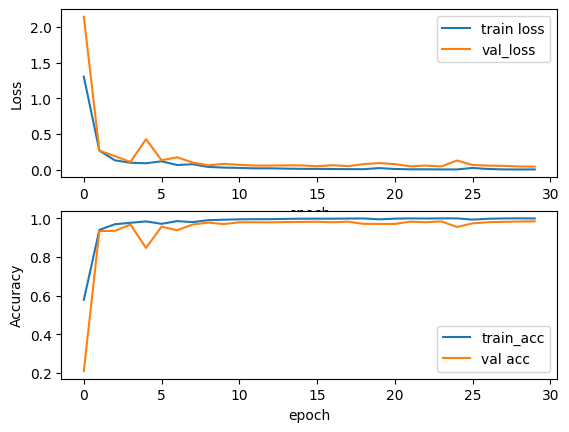

In [ ]:
@dataclass
class SpectrogramParams:
    n_mels: int
    sample_rate: int
    frame_duration: float
    window_length: int
    n_fft: int
    target_length: int


target_duration = 1.1  # target duration in seconds
frame_duration = 0.03  # frame duration in seconds
sample_rate = 16000
window_length = round(frame_duration * sample_rate)

spec_params = SpectrogramParams(
    n_mels=32,
    sample_rate=16000,
    frame_duration=frame_duration,
    window_length=window_length,
    n_fft=2 ** (round(window_length) - 1).bit_length(),
    target_length=round(target_duration * sample_rate),
)

data_labels = {
    "cero": 0,
    "uno": 1,
    "dos": 2,
    "tres": 3,
    "cuatro": 4,
    "cinco": 5,
    "seis": 6,
    "siete": 7,
    "ocho": 8,
    "nueve": 9,
}

if TRAIN:
    training_dataset, _ = create_dataset(
        "audio_data/training", data_labels, spec_params
    )
    validation_dataset, _ = create_dataset(
        "audio_data/validation", data_labels, spec_params
    )

    torch.save(training_dataset, "training_dataset.pt")
    torch.save(validation_dataset, "validation_dataset.pt")

    device = "cpu"

    learning_rate = 0.001
    batch_size = 512

    net = DigitClassifierNet()

    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()

    num_epochs = 30
    train_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(
        validation_dataset, batch_size=batch_size, shuffle=False
    )

    print("\nTraining net:")
    train_losses, val_losses, train_acc, val_acc = train(
        net,
        loss_fn,
        train_dataloader,
        val_dataloader,
        optimizer,
        num_epochs,
        device=device,
    )

    torch.save(net.state_dict(), "digit_classifier_net.pth")

    fig, axes = plt.subplots(2, 1)
    axes[0].plot(train_losses, label="train loss")
    axes[0].plot(val_losses, label="val_loss")
    axes[0].legend()
    axes[0].set_xlabel("epoch")
    axes[0].set_ylabel("Loss")

    axes[1].plot(train_acc, label="train_acc")
    axes[1].plot(val_acc, label="val acc")
    axes[1].legend()
    axes[1].set_xlabel("epoch")
    axes[1].set_ylabel("Accuracy")

Para testear la red he clasificado los digitos de un dataset distinto al de entrenamiento y de validación. En el caso de este dataset de 80 dígitos vemos como la red obtiene un accuracy del 100% sin fallar un solo dígito. También he hecho la matriz de confusión tanto del nuevo dataset como del dataset de validación y marcado las predicciones incorrectas indicando a que grabación corresponden, para obtener información sobre que está fallando y así poder mejorar aún más la red en un futuro.

Random samples from training dataset


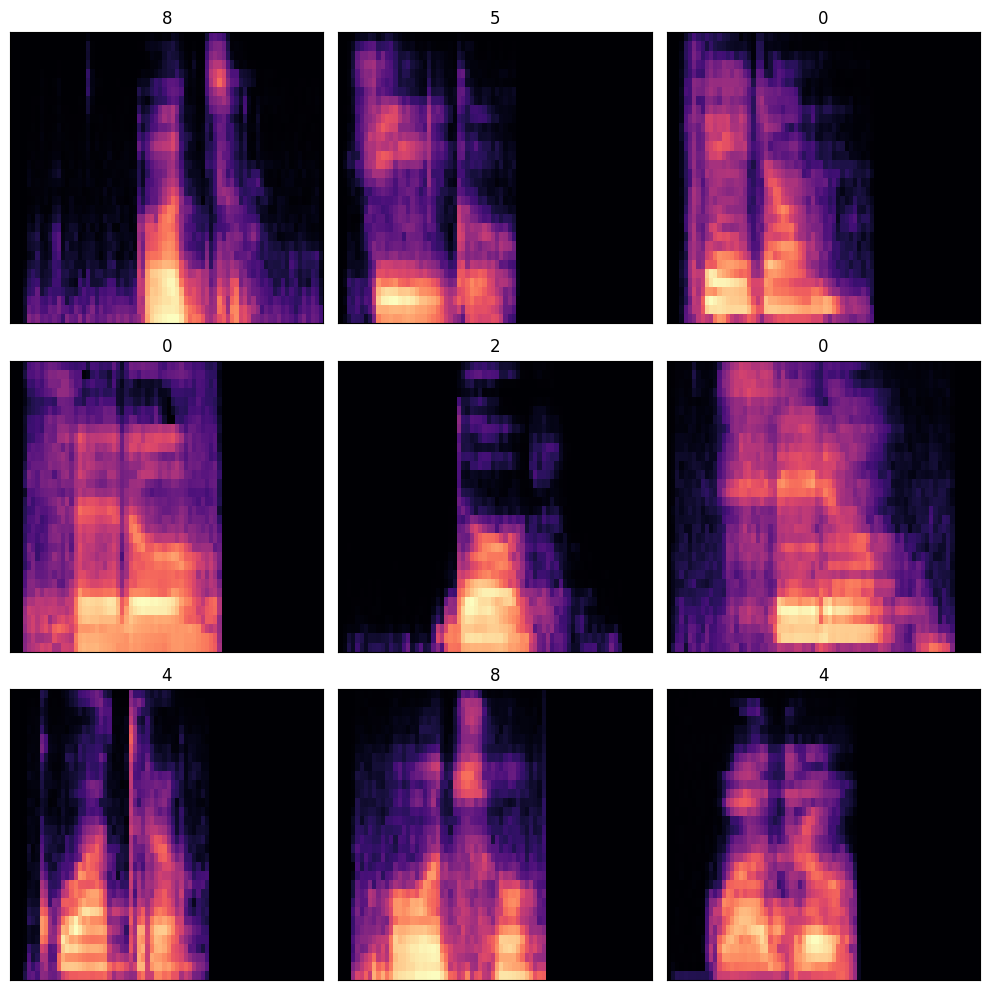

Random samples from validation dataset


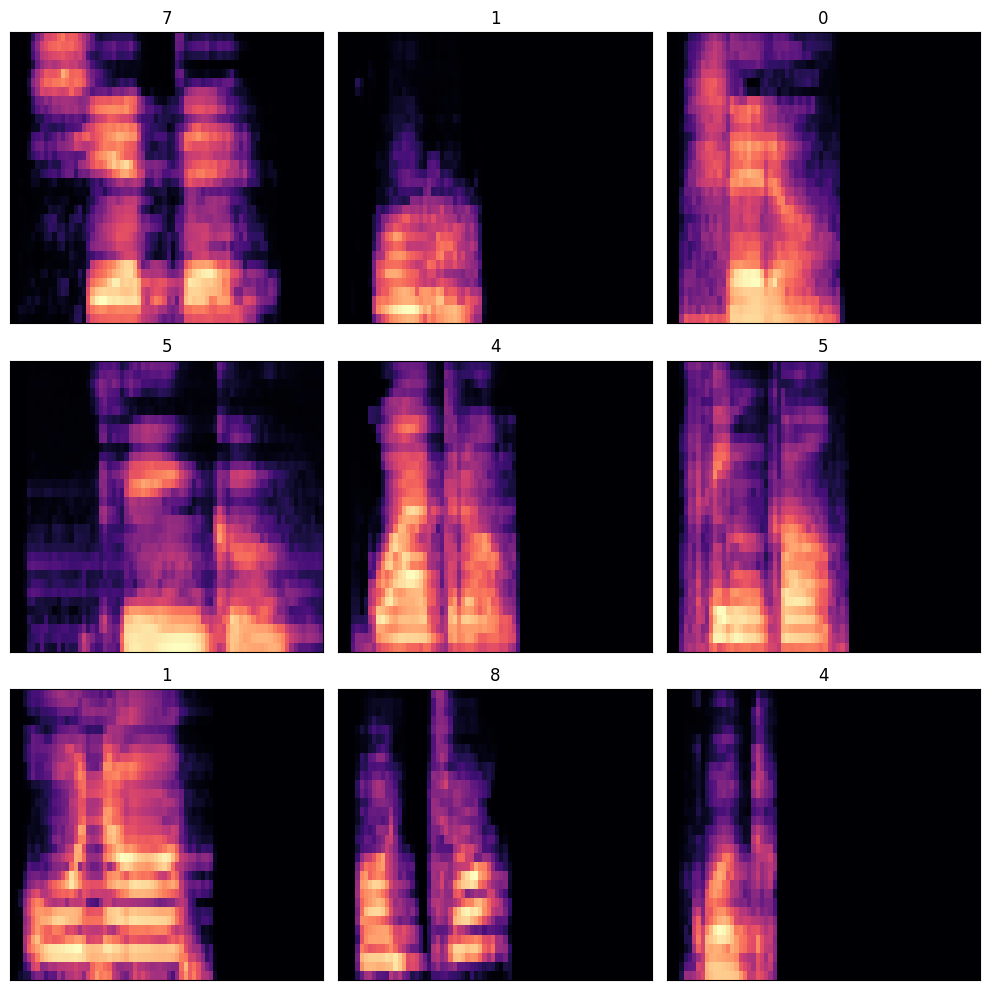

Testing net with audio_data/test:


Creating dataset from audio_data/test...


100%|██████████| 80/80 [00:00<00:00, 300.57it/s]



Accuracy: 100.0%

Wrong predictions:

Confusion Matrix:


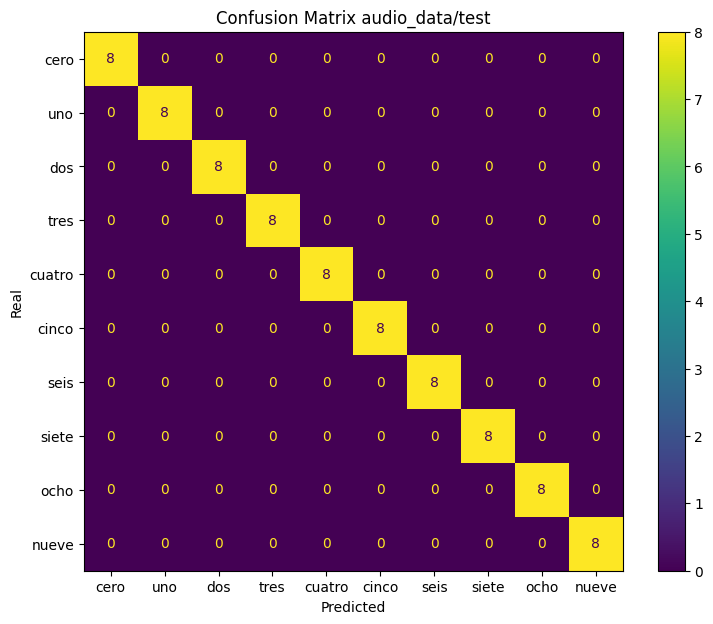

Testing net with audio_data/validation:


Creating dataset from audio_data/validation...


100%|██████████| 3082/3082 [00:10<00:00, 306.11it/s]



Accuracy: 98.44256975989617%

Wrong predictions:
Prediction: 3, Real: 6, File: audio_data/validation/seis/2023_056_AB_seis_5_4.wav
Prediction: 7, Real: 6, File: audio_data/validation/seis/2023_056_AB_seis_4_3.wav
Prediction: 7, Real: 6, File: audio_data/validation/seis/2023_103_AB_seis_1_4.wav
Prediction: 8, Real: 6, File: audio_data/validation/seis/2023_027_AB_seis_38_19.wav
Prediction: 9, Real: 6, File: audio_data/validation/seis/2023_103_AB_seis_5_3.wav
Prediction: 3, Real: 6, File: audio_data/validation/seis/2023_103_AB_seis_5_4.wav
Prediction: 7, Real: 6, File: audio_data/validation/seis/2023_012_AB_seis_2_4.wav
Prediction: 9, Real: 6, File: audio_data/validation/seis/2023_131_AB_seis_2_2.wav
Prediction: 3, Real: 2, File: audio_data/validation/dos/2023_012_AB_dos_5_4.wav
Prediction: 1, Real: 2, File: audio_data/validation/dos/2023_027_AB_dos_13_7.wav
Prediction: 1, Real: 2, File: audio_data/validation/dos/2023_027_AB_dos_33_17.wav
Prediction: 5, Real: 7, File: audio_data/validati

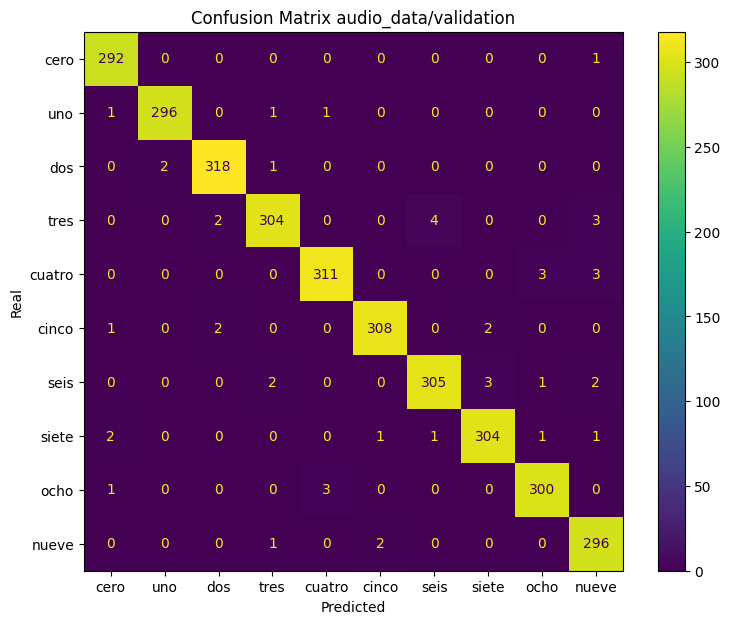

In [ ]:
training_dataset = torch.load("training_dataset.pt")
validation_dataset = torch.load("validation_dataset.pt")

print("Random samples from training dataset")
show_dataset_samples(training_dataset, spec_params)

print("Random samples from validation dataset")
show_dataset_samples(validation_dataset, spec_params)

# load our net
net = DigitClassifierNet()
net.load_state_dict(torch.load("digit_classifier_net.pth"))

# test the model
test_net("audio_data/test", data_labels, spec_params, net)
test_net("audio_data/validation", data_labels, spec_params, net)

Para probar la red en timepo real simplemente hay que ajustar el tiempo de grabación y ejecutar la celda. La red puede reconocer varios dígitos presentes en una sola grabación, siempre se deje un pequeño silencio entre dígitos. Los audios con los que se ha entrenado la red estaban muy bien preparados y segmentados, pero al probar la red en tiempo real se nos pueden colar ruidos de fondo y las grabaciones pueden no ser de la mejor calidad, por lo que he utilizado un VAD basado en un modelo ya entrenado para manejar escenarios más complejos https://github.com/snakers4/silero-vad.

Using cache found in /Users/joan/.cache/torch/hub/snakers4_silero-vad_master


Prediction: 0 , with probability of 99.95%
Prediction: 5 , with probability of 99.71%
Prediction: 8 , with probability of 99.99%
Prediction: 6 , with probability of 99.81%


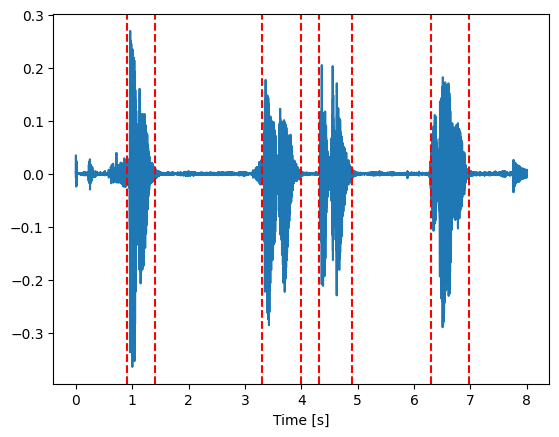

In [ ]:
duration = 8
freq = 16000

# load our net
net = DigitClassifierNet()
net.load_state_dict(torch.load("digit_classifier_net.pth"))

# record audio
record = sd.rec(int(duration * freq), samplerate=freq, channels=1).squeeze()
sd.wait()

# load the VAD model
model, utils = torch.hub.load(repo_or_dir="snakers4/silero-vad", model="silero_vad")
(get_speech_timestamps, _, read_audio, _, _) = utils

# get speech timestamps
speech_timestamps = get_speech_timestamps(record, model, sampling_rate=16000)

# plot the original recorded audio
plt.plot(np.linspace(0, duration, len(record)), record)
plt.xlabel("Time [s]")

# make the predictions for each digit detected
for timestamp in speech_timestamps:
    # save the detected digit
    digit = record[timestamp["start"] : timestamp["end"]]
    write("file.wav", freq, digit)

    # preprocess the audio
    S = preprocess_audio("file.wav", spec_params)

    # make the prediction
    x = torch.from_numpy(S.astype(np.float32))
    x = x.unsqueeze(0).unsqueeze(0)
    x = x.to("cpu")
    y = net(x)
    y = torch.nn.functional.softmax(y, dim=1)

    # get the prediction and the probability
    prediction_probability = torch.max(y).item()
    prediction = torch.argmax(y).item()

    if prediction_probability > 0:
        print(
            f"Prediction: {prediction} , with probability of {prediction_probability * 100:.2f}%"
        )

        # add vertical lines to visualize the detected digits
        plt.axvline(x=timestamp["start"] / freq, color="r", linestyle="--")
        plt.axvline(x=timestamp["end"] / freq, color="r", linestyle="--")

plt.show()